# Pedestrian Forecasting
***

## Preparation

We start by installing the packages we need.

In [1]:
%conda install -c conda-forge sktime
%conda install -c conda-forge seaborn
%conda install -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/studio-lab-user/.conda/envs/default

  added / updated specs:
    - sktime


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1q             |       h166bdaf_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.1 MB

The following packages will be UPDATED:

  openssl                                 1.1.1p-h166bdaf_0 --> 1.1.1q-h166bdaf_0



openssl-1.1.1q       | 2.1 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart 

Import packages.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Data preparation
This dataset contains hourly pedestrian counts since 2009 from pedestrian sensor devices located across the city of Melbourne, Australia. The data is updated on a monthly basis and can be used to determine variations in pedestrian activity throughout the day. https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp

In [3]:
# Read
df = pd.read_csv('data/Pedestrian_Counting_System_-_Monthly__counts_per_hour_.csv', usecols=['Date_Time', 'Sensor_Name', 'Hourly_Counts'])

df.head()

,Date_Time,Sensor_Name,Hourly_Counts
0,"November 01, 2019 05:00:00 PM",Flinders St-Spark La,300
1,"November 01, 2019 05:00:00 PM",Alfred Place,604
2,"November 01, 2019 05:00:00 PM",Lygon St (East),216
3,"November 01, 2019 05:00:00 PM",Lonsdale St-Spring St (West),627
4,"November 01, 2019 05:00:00 PM",Queen St (West),774


In [4]:
# Convert date to datetime
df['Date_Time'] = pd.to_datetime(df['Date_Time'])

# Group all sensors
df_grouped = df.groupby(['Date_Time']).agg({'Hourly_Counts': 'sum'}).rename(columns={'Hourly_Counts': 'Count_Pedestrians'})

# Aggregate weekly
df_weekly = df_grouped.resample('W').sum()

# Filter from the start of 2010 to end of 2019
df_weekly = df_weekly['2010-01-01': '2019-12-31']

In [5]:
df_weekly

,Count_Pedestrians
Date_Time,
2010-01-03,1509634
2010-01-10,1581344
2010-01-17,1614204
2010-01-24,1897725
2010-01-31,1759063
...,...
2019-12-01,5734283
2019-12-08,5880463
2019-12-15,5955164


In [6]:
y = df_weekly.squeeze() # prepare the data as a pandas Series

## Exploratory Data Analysis

We now plot our weekly data.

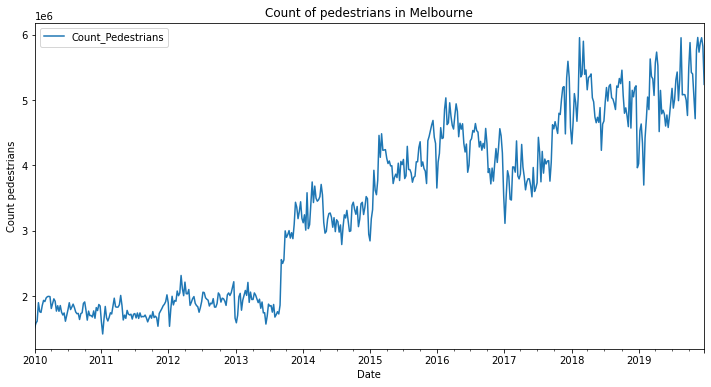

In [7]:
df_weekly.plot(figsize=(12,6), title='Count of pedestrians in Melbourne', xlabel='Date', ylabel='Count pedestrians')
plt.show()

We now aggregate our weekly data to monthly and plot.

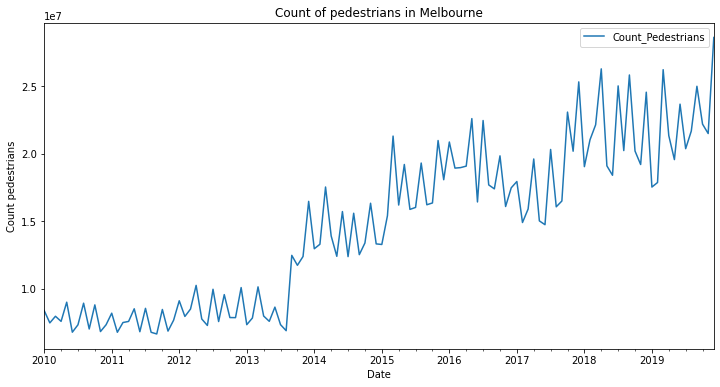

In [8]:
df_weekly.resample('M').sum().plot(figsize=(12,6), title='Count of pedestrians in Melbourne', xlabel='Date', ylabel='Count pedestrians')
plt.show()

We also check if our data is stationary.

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_weekly.values.flatten())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.313204
p-value: 0.923613


We find that our data is non-stationary.

## Forecasting

### Multiple Linear Regression

In [11]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=26) # Predict from 1st July 2019

In [12]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)

In [13]:
from sklearn.linear_model import LinearRegression
from sktime.forecasting.compose import make_reduction

regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=52, strategy="recursive")

In [14]:
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:601: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:611: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/utils/datetime.py:80: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/utils/datetime.py:81: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/utils

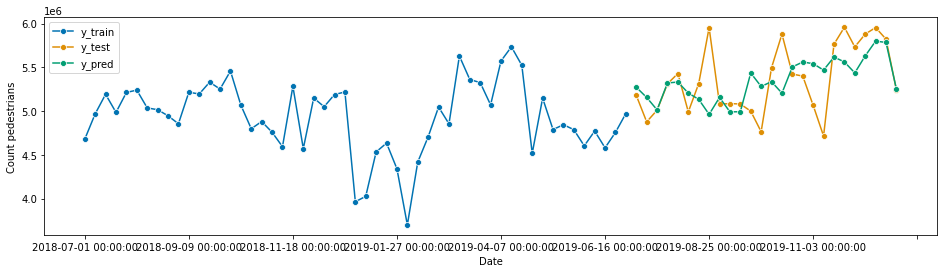

In [15]:
from sktime.utils.plotting import plot_series

plot_series(y_train['2018-07-01':], y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians');

In [16]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

MAPE: 0.0481


### XGBoost with multiple inputs

In [17]:
from xgboost import XGBRegressor

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = make_reduction(regressor, window_length=52, strategy="recursive")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [16]:
# Create an exogenous dataframe indicating the month
X = pd.DataFrame({'month': y.index.month}, index=y.index)
X = pd.get_dummies(X.astype(str), drop_first=True)

# Split into train and test
X_train, X_test = temporal_train_test_split(X, test_size=26) # Predict from 1st July 2019

In [18]:
# Fit
forecaster.fit(y=y_train, X=X_train)

# Predict
y_pred = forecaster.predict(fh=fh, X=X_test)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/utils/datetime.py:108: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if not hasattr(x, "freq") or x.freq is None:
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/utils/datetime.py:110: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  by *= x.freq
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:601: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:611: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime

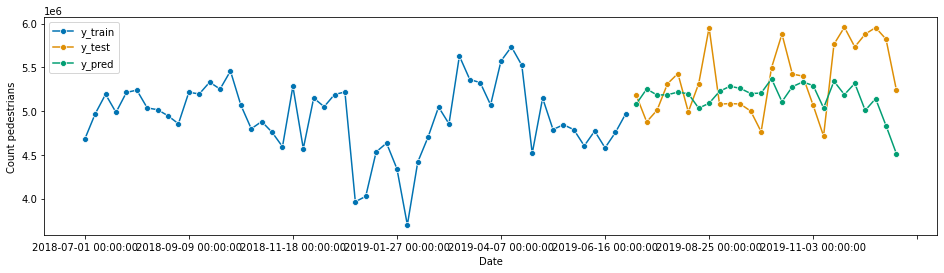

In [19]:
plot_series(y_train['2018-07-01':], y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians');

In [20]:
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

MAPE: 0.0709


### Tuning the hyperparameters of our forecaster
https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

In [21]:
from sktime.forecasting.model_selection import SingleWindowSplitter

validation_size = 26
cv = SingleWindowSplitter(window_length=len(y)-validation_size, fh=validation_size)

In [22]:
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV

param_grid = {
    'estimator__max_depth': [3, 5, 6, 10, 15, 20],
    'estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'estimator__n_estimators': [100, 500, 1000]
}

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = make_reduction(regressor, window_length=52, strategy="recursive")

gscv = ForecastingRandomizedSearchCV(forecaster, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42)

In [23]:
# Fit
gscv.fit(y=y_train, X=X_train)

# Predict
y_pred = gscv.predict(fh=fh, X=X_test)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:601: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:611: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/utils/datetime.py:80: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/utils/datetime.py:81: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/utils

In [24]:
gscv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.385468,5.411095,0.053047,"{'estimator__subsample': 0.5, 'estimator__n_es...",68.0
1,0.312146,1.641992,0.047744,"{'estimator__subsample': 0.5, 'estimator__n_es...",33.0
2,0.054147,3.233747,0.046460,"{'estimator__subsample': 0.5, 'estimator__n_es...",6.0
3,0.378506,0.539400,0.044624,"{'estimator__subsample': 0.6, 'estimator__n_es...",63.0
4,0.393071,3.302983,0.047962,"{'estimator__subsample': 0.8999999999999999, '...",78.0
...,...,...,...,...,...
95,0.349550,0.647016,0.044583,"{'estimator__subsample': 0.8999999999999999, '...",43.0
96,0.361718,0.796901,0.044165,"{'estimator__subsample': 0.7, 'estimator__n_es...",50.0
97,0.366276,1.157752,0.044705,"{'estimator__subsample': 0.7999999999999999, '...",57.0
98,0.402781,8.606014,0.051053,"{'estimator__subsample': 0.6, 'estimator__n_es...",86.0


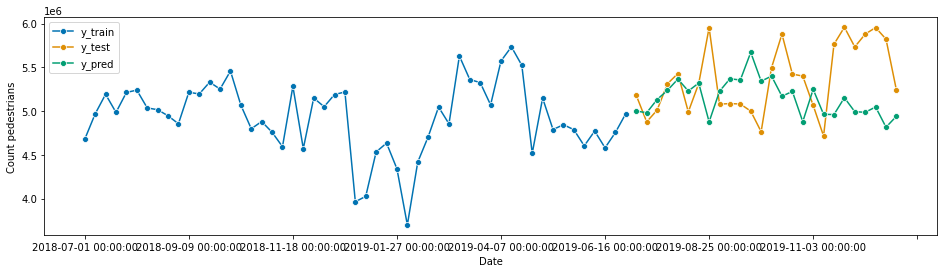

In [25]:
plot_series(y_train['2018-07-01':], y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians');

In [26]:
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

MAPE: 0.0780


## Adding components to our forecasting pipeline

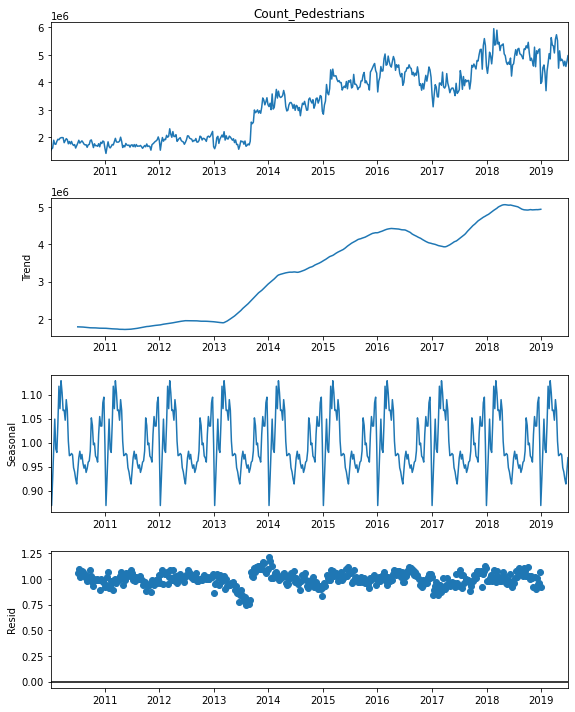

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (8,10)

result = seasonal_decompose(y_train, model='multiplicative')
result.plot()
plt.show()

In [28]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(regressor, window_length=52, strategy="recursive"),
        ),
    ]
)

In [29]:
param_grid = {
    'deseasonalize__model': ['multiplicative', 'additive'],
    'detrend__forecaster__degree': [1, 2, 3],
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15, 20],
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 500, 1000]
}

gscv = ForecastingRandomizedSearchCV(forecaster, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42)

In [30]:
# Fit
gscv.fit(y=y_train, X=X_train)

# Predict
y_pred = gscv.predict(fh=fh, X=X_test)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/utils/datetime.py:80: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/utils/datetime.py:81: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/utils/datetime.py:83: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  elif "-" in x.freqstr:
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/utils/datetime.py:84: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr.split("-")[0]
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:601: FutureWarning: Timestamp.freqstr is 

In [31]:
gscv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.041810,0.422506,0.057544,"{'forecast__estimator__subsample': 0.5, 'forec...",50.0
1,0.010118,1.800580,0.063091,"{'forecast__estimator__subsample': 0.5, 'forec...",25.0
2,0.076390,3.287315,0.062170,"{'forecast__estimator__subsample': 0.5, 'forec...",74.0
3,0.064376,0.665846,0.058478,"{'forecast__estimator__subsample': 0.6, 'forec...",66.0
4,0.003658,5.757842,0.065007,"{'forecast__estimator__subsample': 0.5, 'forec...",10.0
...,...,...,...,...,...
95,0.188338,1.890709,0.063943,"{'forecast__estimator__subsample': 0.5, 'forec...",99.0
96,0.061729,3.308679,0.072983,"{'forecast__estimator__subsample': 0.6, 'forec...",62.0
97,0.061968,0.376937,0.059999,"{'forecast__estimator__subsample': 0.7, 'forec...",64.0
98,0.134209,1.192860,0.058331,{'forecast__estimator__subsample': 0.799999999...,96.0


In [32]:
gscv.cv_results_.iloc[0, 3]

{'forecast__estimator__subsample': 0.5,
 'forecast__estimator__n_estimators': 100,
 'forecast__estimator__max_depth': 10,
 'forecast__estimator__learning_rate': 0.3,
 'forecast__estimator__colsample_bytree': 0.5,
 'forecast__estimator__colsample_bylevel': 0.5,
 'detrend__forecaster__degree': 2,
 'deseasonalize__model': 'multiplicative'}

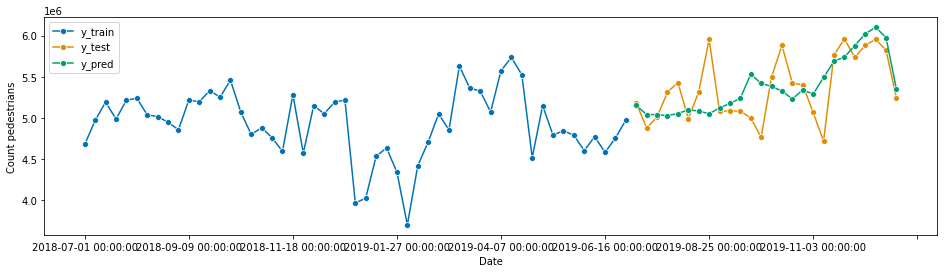

In [33]:
plot_series(y_train['2018-07-01':], y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians');

In [34]:
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

MAPE: 0.0472
